<a href="https://colab.research.google.com/github/Anup2907/salarypredictionportfolio/blob/master/Salary_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. DEFINE

#Using 4D Data Science framework to predict salaries of employees from their qualifications and job locations with MSE as metric

In [0]:
#My info here
__author__ = "Anup Kumar Chittimalla"
__email__ = "anup.chitts@gmail.com"

#Installing catboost
!pip install catboost

#import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns ; sns.set(color_codes=True)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats as sts
from statsmodels.stats.diagnostic import het_breuschpagan as bp
from statsmodels.stats.stattools import durbin_watson as dw
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

'''========================================================================================    
  Machine Learning template for Regression & Classification datasets that can be used by 
  calling the required functions from the respective classes:

  Class Data :          Contains functions load_file, consolidate_data, data_info, 
                        categorical_cols, numerical_cols, missing_data, potential_outlier, 
                        clean_data, obj_to_cat, label_encode, one_hot_encode

  Class Regr_assump :   Contains functions target_dist, vif, ols_summ (joint_plot, QQ_plot) 

  Class Descrip_stats : Contains functions describe, hist, log_transform, scatter_plot,
                        count_box_plot

  Class Feat_engg :     Contains group_mean, group_median, group_std, group_max, group_min

  Class Model :         Contains train_model, test_results, print_summary, save_results 
  ========================================================================================='''                           

class Data:
    
  def __init__(self,target_var):
    self.target_var = target_var
  
  def load_file(file):
    '''loads csv to pd dataframe'''
    return pd.read_csv(file)
  
  def consolidate_data(df1, df2, key=None, left_index=False, right_index=False):
    '''perform inner join to return only records that are present in both dataframes'''
    return pd.merge(left=df1, right=df2, on=key, left_index=left_index, right_index=right_index)
  
  def data_info(file, verbose=True):
    '''checks length and dtypes of dataframes'''
    return file.info(verbose=verbose)
  
  def categorical_cols(df):
    '''Identifies categorical data from other datatypes'''
    cat_cols = df.select_dtypes(include = 'O')
    categorical_cols = list(cat_cols.columns.values)
    return categorical_cols
  
  def numerical_cols(df):
    '''Identifies numerical data from other datatypes'''
    num_cols = df.select_dtypes(include = [np.number])
    numerical_cols = list(num_cols.columns.values)
    return numerical_cols
  
  def missing_data(df):
    '''returns missing data percentage in dataframe'''
    return df.isnull().sum()/len(df)*100
            
  def potential_outlier(df):
    '''detects potential outliers using IQR'''
    stat = df[target_var].describe()
    IQR = stat['75%'] - stat['25%']
    upper = stat['75%'] + 1.5 * IQR
    lower = stat['25%'] - 1.5 * IQR
    print("stat:\t {}".format(stat))
    print("-----------------------------------------------------")
    print("IQR:\t {}".format(IQR))
    print("upper:\t {}".format(upper))
    print("lower:\t {}".format(lower))
    print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

  def clean_data(raw_df):
    '''remove rows that contain salary <= 8.5 (lower band) or duplicate job IDs'''
    duplicate = raw_df.duplicated().sum()
    clean_df = raw_df.drop_duplicates(subset='jobId')
    print("---------------------------------------------------------------------")
    print("There are {} duplicate rows that have been removed".format(duplicate))
    print("---------------------------------------------------------------------")
    lowbandrows = clean_df[clean_df.salary <= 8.5]
    clean_df = clean_df[clean_df.salary > 8.5]
    print("{} rows that contain salary <=8.5 have been removed".format(lowbandrows))
    return clean_df
    
  def obj_to_cat(df):
    '''changing dtype from object to category'''
    columns = ['companyId', 'jobType', 'degree', 'major', 'industry']
    for col in columns:
        df[col] = df[col].astype('category')
    return df.dtypes    
  
  def label_encode(label_df,col):
    '''encode the categories using avg salary for each category to replace label'''
    cat_dict = {}
    cats = label_df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = label_df[label_df[col] == cat]['salary'].mean()
    label_df[col] = label_df[col].map(cat_dict)

  def one_hot_encode(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and combines result with continous 
       variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)


class Regr_assump:
    
  def __init__(self,target_var):
    self.target_var = target_var
  
  #target variable normal distribution check            
  def target_dist(df):
    '''visualizing distribution of target variable'''
    plt.figure(figsize = (14,6))
    plt.subplot(1,2,1)
    sns.boxplot(df[target_var])
    plt.subplot(1,2,2)
    sns.distplot(df[target_var], bins=20)
    return plt.show()
  
  #Multicollinearity and linearity check
  def correlation(self,df):
    '''correlations between selected features'''
    plt.figure(figsize=(12,10))
    sns.heatmap(df[self + [target_var]].corr(), cmap = 'coolwarm', annot=True)
    plt.xticks(rotation=45)
    return plt.show() 
  
  def vif(self,df):
    '''checking multicollinearity through VIF value'''
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif = [variance_inflation_factor(df[self].values, i) for i in range(df[self].shape[1])]
    return dict(zip(vif["variables"], vif))

  #Autocorrelation (Durbin Watson test) and residual normality (Jarque bera test) using OLS summary
  def ols_summ(self,df):
    '''Ordinary least squares summary'''
    X = df[self]
    y = df[target_var]
    X = sm.add_constant(df[self])
    model = sm.OLS(y,X).fit()
    resids = model.resid
    return model.summary()
    print("------------------------------------------------------------------------")
    '''Residual normality dsitribution using QQ plot'''   
    sm.qqplot(resids, dist="norm", plot=plt)
    plt.title("Q-Q plot for residual normality distribution")
    return plt.show()

  #Homoscedasticity using residual plots  
  def resid_plot(self,df):
    '''residual plots between numerical features'''
    sns.residplot(x=self, y=target_var, data=df, color='green')
    plt.xlabel(self)
    plt.ylabel(target_var)
    return plt.show()  
        
      
class Descrip_stats:
    
  def __init__(self,target_var):
    self.target_var = target_var
      
  def describe(self,df):
    p = df[self].describe()
    return p
  
  #Checking the distributions of numerical variables
  def hist(self,df):
    '''Histogram for numerical variables'''
    df[self].hist()
    plt.xlabel(self)
    return plt.show()
  
  #Logarithm transformation 
  def log_transform(self,df):
    '''If numerical variables are not normal, log transformation can make it normal'''
    temp = df[df[self] != 0]
    temp = temp[self].apply(np.log)
    temp.hist()
    plt.xlabel(self)
    return plt.show()

  #Scatter plot        
  def lm_plot(self,df):
      '''Checking scatter plot of numeric variables with target variable'''
      sns.lmplot(x=self, y=target_var, data=df, line_kws={'color': 'red'})
      plt.xlabel(self)
      plt.ylabel(target_var)
      return plt.show()
  
  #Checking the counts and percentiles of categorical variables
  def count_box_plot(self,df):
      '''count and box plots of categorical variables'''
      sns.set(style="darkgrid")
      plt.figure(figsize = (14,6))
      plt.subplot(1,2,1)
      sns.countplot(x=self, data=df)
      plt.xlabel(self)
      plt.xticks(rotation=45)
      print("----------------------------------------------------------------------------------------------------------------") 
      plt.subplot(1,2,2)
      sns.boxplot(y=target_var, x=self, data=df)
      plt.xticks(rotation=45)
      return plt.show() 
          

class Feat_engg:
  '''=============================================================================================
       We can run models by adding one feature at a time or try different combinations of features
       to run the models and consider the features that yields best results (lower MSE). Created 
       different functions for each feature.
     ==========================================================================================='''
    
  def __init__(self, cats_cols, target_var):
    self.cats_cols = cats_cols
    self.target_var = target_var
        
  def group_mean(df):
    '''calculates the salary mean grouping categorical columns'''
    a = df.groupby(cats_cols).mean()
    a = a[target_var].reset_index()
    a.rename({target_var: "group_mean"}, inplace=True, axis=1)
    df = df.merge(a, how = "left", on = cats_cols)
    return df
    
  def group_median(df):
    '''calculates the salary median grouping categorical columns'''
    b = df.groupby(cats_cols).median()
    b = b[target_var].reset_index()
    b.rename({target_var: "group_median"}, inplace=True, axis=1)
    df = df.merge(b, how = "left", on = cats_cols)
    return df
  
  def group_std(df):
    '''calculates the salary standard deviation grouping categorical columns'''
    c = df.groupby(cats_cols).std()
    c = c[target_var].reset_index()
    c.rename({target_var: "group_std"}, inplace=True, axis=1)
    df = df.merge(c, how = "left", on = cats_cols)
    return df
      
  def group_max(df):
    '''calculates the salary maximum grouping categorical columns'''
    d = df.groupby(cats_cols).max()
    d = d[target_var].reset_index()
    d.rename({target_var: "group_max"}, inplace=True, axis=1)
    df = df.merge(d, how = "left", on = cats_cols)
    return df
  
  def group_min(df):
    '''calculates the salary minimum grouping categorical columns'''
    e = df.groupby(cats_cols).min()
    e = e[target_var].reset_index()
    e.rename({target_var: "group_min"}, inplace=True, axis=1)
    df = df.merge(e, how = "left", on = cats_cols)
    return df


class Model:

  def __init__(self, target_var):
    self.target_var = target_var

  def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std ):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=5, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

  def test_results(model,X_train, X_test, y_train, y_test ):
      model.fit(X_train,y_train)
      Test_pred = model.predict(X_test)
      Test_MSE[model] = mean_squared_error(y_test,Test_pred)
      print('Test MSE:\n', Test_MSE[model])
    
  def print_summary(model, mean_mse, cv_std):
      print('\nModel:\n', model)
      print('Average MSE:\n', mean_mse[model])
      print('Standard deviation during CV:\n', cv_std[model])
    
  def save_results(model, mean_mse, predictions, feature_importances):
      '''saves model, model summary, feature importances, and predictions'''
      with open('model.txt', 'w') as file:
          file.write(str(model))
      feature_importances.to_csv('feature_importances.csv') 
      np.savetxt('predictions.csv', predictions, delimiter=',')


In [8]:
if __name__ == '__main__':
  from google.colab import files
  uploaded = files.upload()


Saving test_features.csv to test_features.csv
Saving train_features.csv to train_features.csv
Saving train_salaries.csv to train_salaries.csv


#2. DISCOVER THE DATA

In [9]:
  train_feature_file = 'train_features.csv'
  train_target_file = 'train_salaries.csv'
  test_feature_file = 'test_features.csv'

  #define target variable
  target_var = 'salary'

  #load data
  print("Loading data")
  feature_df = Data.load_file(train_feature_file)
  target_df = Data.load_file(train_target_file)
  test_df = Data.load_file(test_feature_file)

Loading data


In [0]:
  #consolidate training data
  raw_train_df = Data.consolidate_data(feature_df, target_df, key='jobId')
    

In [11]:
  #dataframe length and dtypes 
  Data.data_info(raw_train_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [12]:
  #identify categorical columns
  cats_cols = Data.categorical_cols(raw_train_df)
  cats_cols.remove('jobId')
  print(cats_cols)  

['companyId', 'jobType', 'degree', 'major', 'industry']


In [13]:
  #identify numerical columns
  nums_cols = Data.numerical_cols(raw_train_df)
  print(nums_cols)

['yearsExperience', 'milesFromMetropolis', 'salary']


In [14]:
  #check missing value percentage
  Data.missing_data(raw_train_df)
    

jobId                  0.0
companyId              0.0
jobType                0.0
degree                 0.0
major                  0.0
industry               0.0
yearsExperience        0.0
milesFromMetropolis    0.0
salary                 0.0
dtype: float64

In [0]:
raw_train_df['salary'].describe()

Dependent variable Salary column has 0 salaries which needs to be removed.

In [15]:
  #check potential outliers
  Data.potential_outlier(raw_train_df)

stat:	 count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
-----------------------------------------------------
IQR:	 53.0
upper:	 220.5
lower:	 8.5
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


Examining the potential outliers.

In [16]:
raw_train_df[raw_train_df.salary > 220.5]['jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

All the C level executives have salaries above 220.5k as expected but there are some Junior positions having salaries >220k. Let's check from which industries, Junior positions have above 220k salaries

In [18]:
raw_train_df[(raw_train_df.salary > 220.5) & (raw_train_df.jobType == 'JUNIOR')].industry.value_counts()

OIL        11
FINANCE     8
WEB         1
Name: industry, dtype: int64

Oil and finance industries are known for higher salaries so this data looks legitimate.

Let's look at employees who have less than 8k salaries

In [19]:
raw_train_df[raw_train_df.salary < 8.5].jobType.value_counts()

JUNIOR            2
CTO               1
MANAGER           1
VICE_PRESIDENT    1
Name: jobType, dtype: int64

This looks weird, it might have got recorded mistakenly. Let's remove the data!

In [24]:
  #cleaning the data, removing records below lower band
  clean_df = Data.clean_data(raw_train_df)

---------------------------------------------------------------------
There are 0 duplicate rows that have been removed
---------------------------------------------------------------------
                   jobId companyId  ... milesFromMetropolis salary
30559   JOB1362684438246    COMP44  ...                   7      0
495984  JOB1362684903671    COMP34  ...                  25      0
652076  JOB1362685059763    COMP25  ...                  60      0
816129  JOB1362685223816    COMP42  ...                   6      0
828156  JOB1362685235843    COMP40  ...                  29      0

[5 rows x 9 columns] rows that contain salary <=8.5 have been removed


In [27]:
  #changing dtype from object to category
  Data.obj_to_cat(clean_df)

jobId                    object
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

As most of the variables are categorical, we cannot check the correlations between variables. Hence doing the mean label encoding to check correlations if there is dependence between independent variables

In [0]:
  #label encoding  with mean salary to check the correlations
  label_df = clean_df.copy()
  for col in label_df.columns:
      if label_df[col].dtype.name == 'category':
          Data.label_encode(label_df,col)

In [29]:
  label_df.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,115.345049,135.458547,130.505647,133.322042,115.735540,10,83,130
1,JOB1362684407688,115.756548,145.311425,101.921085,102.583864,121.645362,3,73,101
2,JOB1362684407689,116.224249,125.368630,135.490979,130.372436,115.735540,10,38,137
3,JOB1362684407690,116.199380,115.368518,135.490979,129.072085,109.435222,8,17,142
4,JOB1362684407691,115.888501,125.368630,125.454663,130.372436,130.747659,8,16,163


Now the converting the datatypes of categorical features to numerical

In [31]:
#converting the datatypes to int to get correlation matrix
for v in cats_cols:
  label_df[v] = label_df[v].astype(int)
label_df.dtypes

jobId                  object
companyId               int64
jobType                 int64
degree                  int64
major                   int64
industry                int64
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

#Descriptive Statistics

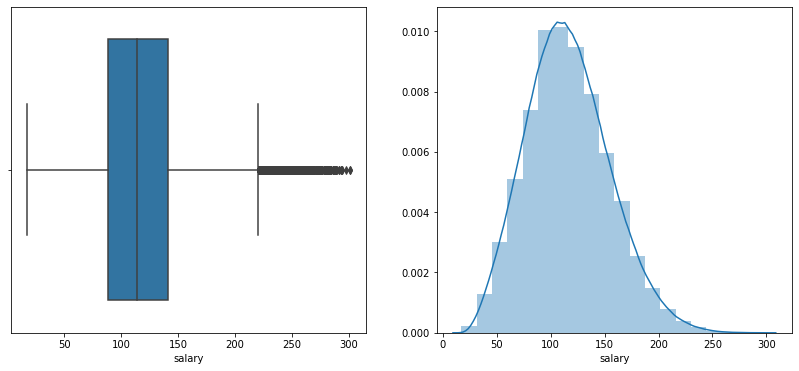

In [32]:
    #target variable distribution
    Regr_assump.target_dist(clean_df)

Target variable "salary" is normally distributed which is the one of the assumptions of Regression

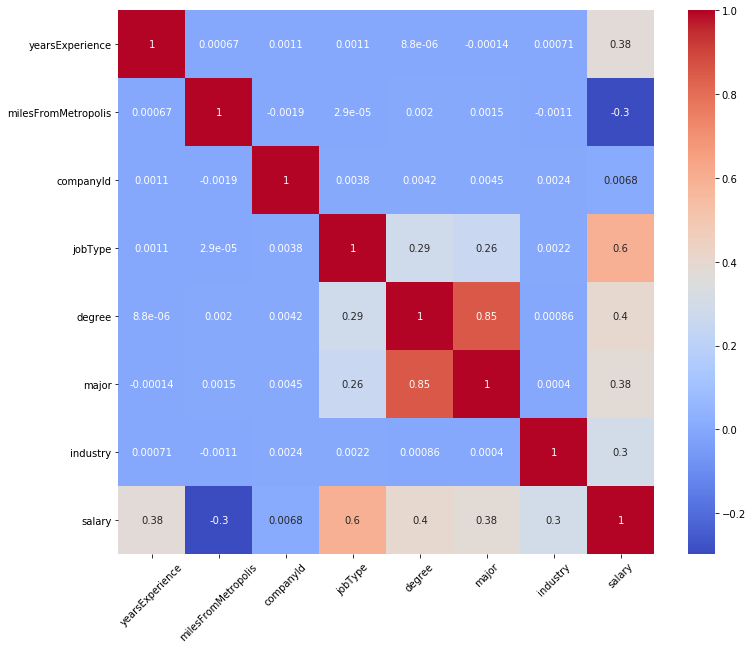

In [33]:
    #correlation matrix using heatmap
    features = ['yearsExperience', 'milesFromMetropolis','companyId', 
                'jobType', 'degree', 'major', 'industry']
    Regr_assump.correlation(features,label_df) 

From the correlation matrix, it is evident that degree and major are correlated with pearson's coefficient of 0.85

In [49]:
  #Describe numerical columns
  Descrip_stats.describe('yearsExperience',clean_df)

count    999995.000000
mean         11.992407
std           7.212390
min           0.000000
25%           6.000000
50%          12.000000
75%          18.000000
max          24.000000
Name: yearsExperience, dtype: float64

In [48]:
 Descrip_stats.describe('milesFromMetropolis',clean_df)

count    999995.000000
mean         49.529381
std          28.877721
min           0.000000
25%          25.000000
50%          50.000000
75%          75.000000
max          99.000000
Name: milesFromMetropolis, dtype: float64

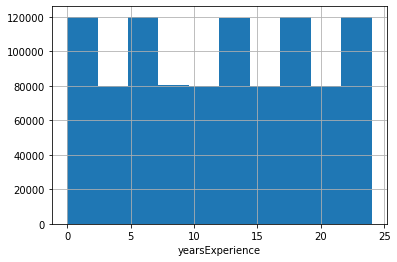

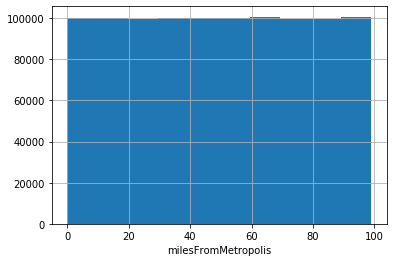

In [50]:
  #Histogram for numerical columns
  Descrip_stats.hist('yearsExperience',clean_df)
  Descrip_stats.hist('milesFromMetropolis',clean_df)

The distributions of histograms are quite weird but as the years of experience and miles from metropolis numbers cannot be negative. Hence the distributions need not be normal, hence not transforming the numerical variables

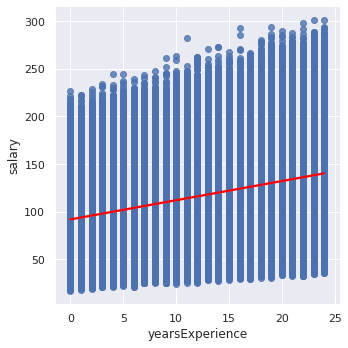

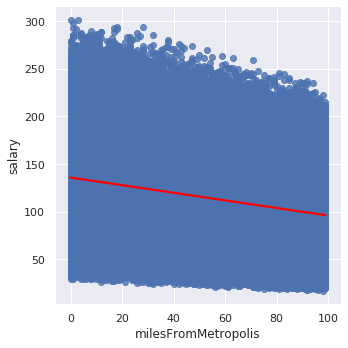

In [62]:
  #linear plots of numerical variables with target variable
  Descrip_stats.lm_plot('yearsExperience',clean_df)
  Descrip_stats.lm_plot('milesFromMetropolis',clean_df)

As already we have seen from the correlation matrix that the co-efficient of correlation between years of experience and salary is 0.38 and between milles from metropolis and salary is -0.3. Now from the linear plots it is evident that 


1.   Years of experience is linearly related to Salary (As YoE increases Salary increases)
2.   Miles from metropolis is non-linearly related to Salary (As MfM increases Salary decreases)



----------------------------------------------------------------------------------------------------------------


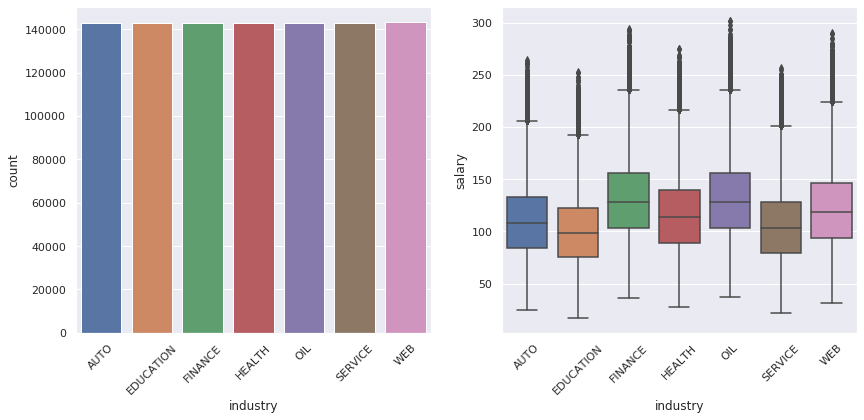

----------------------------------------------------------------------------------------------------------------


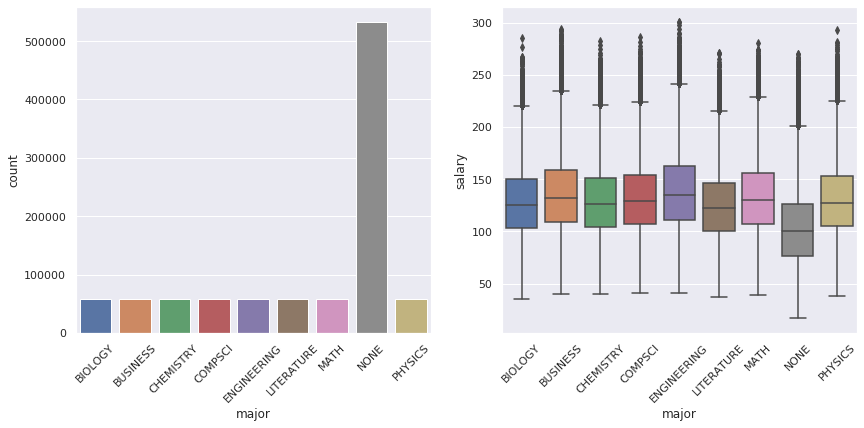

----------------------------------------------------------------------------------------------------------------


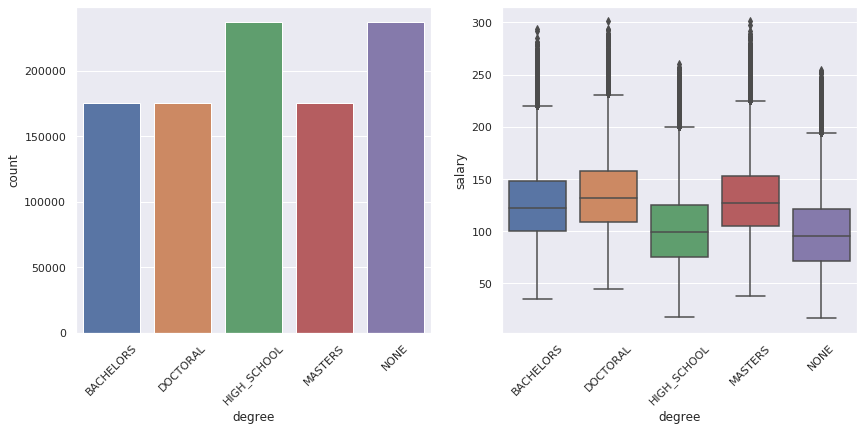

----------------------------------------------------------------------------------------------------------------


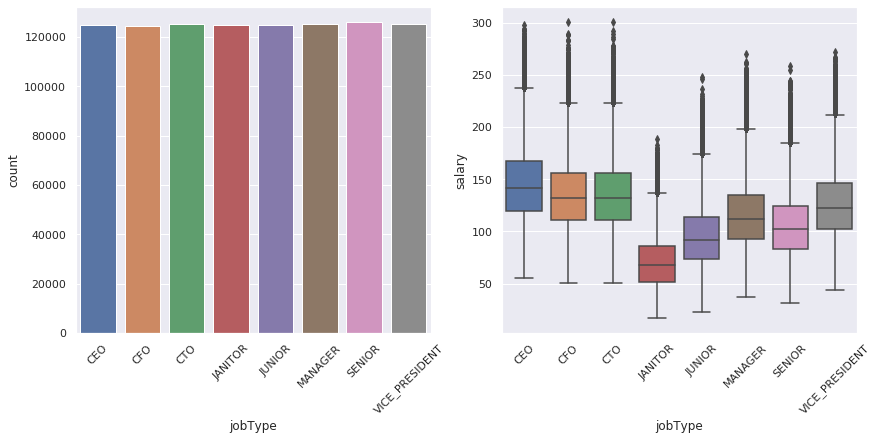

In [67]:
  #count and box plots of selected variables
  features = ['industry','major','degree','jobType']
  for feat in features:
      Descrip_stats.count_box_plot(feat,clean_df)

The count of employees who have their degree "None" is pretty high but we can't just interpret those employees doesn't have a degree. This is a good example of data collection is done improperly or mistakes are made in data entry.

#3. DEVELOP 

#Feature Engineering


Creating new features grouping categorical variables for better results during modeling 

In [0]:
  #Creating new features such as salary mean, median, std, max, min
  clean_mean = Feat_engg.group_mean(clean_df)
  clean_med_mean = Feat_engg.group_median(clean_mean)
  clean_med_mean_std = Feat_engg.group_std(clean_med_mean)  
  clean_med_mean_std_max = Feat_engg.group_max(clean_med_mean_std)  
  clean_feats = Feat_engg.group_min(clean_med_mean_std_max)

In [69]:
  Data.data_info(clean_feats)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999994
Data columns (total 14 columns):
jobId                  999995 non-null object
companyId              999995 non-null category
jobType                999995 non-null category
degree                 999995 non-null category
major                  999995 non-null category
industry               999995 non-null category
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
group_mean             999995 non-null float64
group_median           999995 non-null float64
group_std              999074 non-null float64
group_max              999995 non-null float64
group_min              999995 non-null float64
dtypes: category(5), float64(5), int64(3), object(1)
memory usage: 81.1+ MB


"group_std" variable has missing values, hence replacing the null values with 0

In [71]:
  #imputing missing values of standard deviation with 0 as the percentage is very small
  clean_feats['group_std'] = clean_feats['group_std'].fillna(0)
  Data.data_info(clean_feats)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999994
Data columns (total 14 columns):
jobId                  999995 non-null object
companyId              999995 non-null category
jobType                999995 non-null category
degree                 999995 non-null category
major                  999995 non-null category
industry               999995 non-null category
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
group_mean             999995 non-null float64
group_median           999995 non-null float64
group_std              999995 non-null float64
group_max              999995 non-null float64
group_min              999995 non-null float64
dtypes: category(5), float64(5), int64(3), object(1)
memory usage: 81.1+ MB


In [72]:
clean_feats.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,group_mean,group_median,group_std,group_max,group_min
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,130.875000,136.0,19.555324,150.0,98.0
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,138.031250,132.0,29.306248,204.0,90.0
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,142.000000,137.0,28.827071,173.0,116.0
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,129.000000,131.0,29.251781,169.0,77.0
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,153.583333,141.5,46.310137,232.0,94.0


In [73]:
  #Label Encoding new dataframe after feature engineering
  for col in cats_cols:
      le = preprocessing.LabelEncoder()
      clean_feats[col] = le.fit_transform(clean_feats[col].astype(str))
      clean_feats[col] = clean_feats[col].astype('category')
  clean_feats.head(5) 

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,group_mean,group_median,group_std,group_max,group_min
0,JOB1362684407687,31,1,3,6,3,10,83,130,130.875000,136.0,19.555324,150.0,98.0
1,JOB1362684407688,11,0,2,7,6,3,73,101,138.031250,132.0,29.306248,204.0,90.0
2,JOB1362684407689,48,7,1,8,3,10,38,137,142.000000,137.0,28.827071,173.0,116.0
3,JOB1362684407690,32,5,1,2,0,8,17,142,129.000000,131.0,29.251781,169.0,77.0
4,JOB1362684407691,60,7,0,8,2,8,16,163,153.583333,141.5,46.310137,232.0,94.0


In [74]:
clean_feats.dtypes

jobId                    object
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
group_mean              float64
group_median            float64
group_std               float64
group_max               float64
group_min               float64
dtype: object

#Model building

In [0]:
  #Splitting the dependent and independent variables
  X = pd.DataFrame(clean_feats.drop(columns=['salary','jobId']))
  y = pd.DataFrame(clean_feats['salary'], index=None)


In [0]:
  #Splitting the dataset into the Training set and Test set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                            random_state = 77)

In [0]:
#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}
res = {}
Test_MSE = {}

Creating a pipeline for dataprocessing and model building

Firstly models with default parameters are run with 5-fold Cross Validation and then the best model is selected and the hyperparameters are tuned by different methods

The models selected are:

1. Linear Regression
2. Linear Regression with feature scaling and PCA
3. Random Forest Regressor
4. LightGBM Regressor

In [123]:
#Creating model objects for each model with default parameters which we will fine tune the hyperparameters later.
lr = LinearRegression()
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
rf = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, 
                           min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                           max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                           bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
                           warm_start=False, ccp_alpha=0.0, max_samples=None)
lgbm = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=10, max_depth=-1, learning_rate=0.1, 
                         n_estimators=50,
                         subsample_for_bin=50000, objective=None, class_weight=None, 
                         min_split_gain=0.0, min_child_weight=0.001,min_child_samples=10, subsample=1.0, 
                         subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, 
                         random_state=None, n_jobs=-1, silent=True, importance_type='split') 

models.extend([lr, lr_std_pca, rf, lgbm])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    Model.train_model(model, X_train, y_train, num_procs, mean_mse,cv_std)
    Model.test_results(model,X_train, X_test, y_train, y_test)
    Model.print_summary(model, mean_mse, cv_std)

#choose model with lowest mse
    model = min(mean_mse, key=mean_mse.get)
    print('\nPredictions calculated using model with lowest MSE:')
    print(model)    

Beginning cross validation
Test MSE:
 356.11363026948317

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average MSE:
 358.85520736772787
Standard deviation during CV:
 1.0286780900991113

Predictions calculated using model with lowest MSE:
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs

KeyboardInterrupt: ignored

#4. DEPLOY

In [0]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
for mod in models:
  joblib.dump(mod, 'filename.pkl') 
  
# Load the model from the file 
rfc_from_joblib = joblib.load('filename.pkl')